In [ ]:
#Importing modules
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)


In [ ]:
#to read
def read_data(filename):
    file= open(filename,mode="rt",encoding='UTF-8')#TO OPEN
    text = file.read()
    file.close()
    return text
    

In [ ]:
def to_lines(text):
      sents = text.strip().split('\n') #formed sentences
      sents = [i.split('\t') for i in sents]
      return sents

In [ ]:
file = read_data("/content/drive/MyDrive/GERMAN_ENGLISH_TRANSLATOR/deu.txt")
ger_eng = to_lines(file)
ger_eng=array(ger_eng)#converted to array

ger_eng = ger_eng[:50000,:2]#we ned 1st 5000 rows
print(ger_eng)


[['Go.' 'Geh.']
 ['Hi.' 'Hallo!']
 ['Hi.' 'Grüß Gott!']
 ...
 ['Who else is in there?' 'Wer ist noch dort drin?']
 ['Who else was in here?' 'Wer war sonst noch hier drin?']
 ['Who fixed the window?' 'Wer hat das Fenster hergerichtet?']]


In [ ]:
#Text Pre-Processing
#cleaning
# Remove punctuation
ger_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ger_eng[:,0]]
ger_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ger_eng[:,1]]

In [ ]:
print(ger_eng)

[['Go' 'Geh']
 ['Hi' 'Hallo']
 ['Hi' 'Grüß Gott']
 ...
 ['Who else is in there' 'Wer ist noch dort drin']
 ['Who else was in here' 'Wer war sonst noch hier drin']
 ['Who fixed the window' 'Wer hat das Fenster hergerichtet']]


In [ ]:
for i in range(len(ger_eng)):
    ger_eng[i,0] = ger_eng[i,0].lower()
    ger_eng[i,1] = ger_eng[i,1].lower()

In [ ]:
# Text to Sequence Conversion


ger=[]
eng =[]
for i in ger_eng[:,0]:
      eng.append(len(i.split()))

for i in ger_eng[:,1]:
      ger.append(len(i.split()))


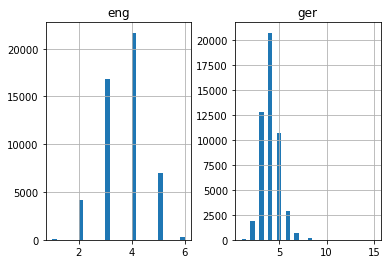

In [ ]:
length_df = pd.DataFrame({'eng':eng, 'ger':ger}) #converting to pd dataframe

length_df.hist(bins = 30)#ploting histogram
plt.show()

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
# prepare english tokenizer
eng_tokenizer = tokenization(ger_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8

In [ ]:
#german tokenizer
ger_tokenizer = tokenization(ger_eng[:,1])
ger_vocab_size = len(ger_tokenizer.word_index)+1
ger_length = 8

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [ ]:
#Model Building
#We will now split the data into train and test set for model training and evaluation, respectively
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test  = train_test_split(ger_eng, test_size=0.2, random_state = 12)

In [ ]:
#We will encode German sentences as the input sequences and English sentences as the target sequences. 
# prepare training data
X_train = encode_sequences(ger_tokenizer, ger_length, train[:, 1])
Y_train = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [ ]:
# prepare validation data
X_test = encode_sequences(ger_tokenizer, ger_length, test[:, 1])
Y_test = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [ ]:
# model compilation
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, 512)

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
filename = 'translation_model'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(X_train, Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
63/63 [==============================] - 29s 99ms/step - loss: 4.3165 - val_loss: 2.8071

Epoch 00001: val_loss improved from inf to 2.80708, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 2/30
63/63 [==============================] - 5s 73ms/step - loss: 2.7173 - val_loss: 2.7058

Epoch 00002: val_loss improved from 2.80708 to 2.70578, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 3/30
63/63 [==============================] - 5s 72ms/step - loss: 2.5919 - val_loss: 2.5356

Epoch 00003: val_loss improved from 2.70578 to 2.53559, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 4/30
63/63 [==============================] - 5s 73ms/step - loss: 2.4224 - val_loss: 2.4049

Epoch 00004: val_loss improved from 2.53559 to 2.40491, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 5/30
63/63 [==============================] - 5s 74ms/step - loss: 2.2611 - val_loss: 2.2806

Epoch 00005: val_loss improved from 2.40491 to 2.28056, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 6/30
63/63 [==============================] - 5s 73ms/step - loss: 2.1140 - val_loss: 2.1633

Epoch 00006: val_loss improved from 2.28056 to 2.16329, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 7/30
63/63 [==============================] - 5s 74ms/step - loss: 1.9712 - val_loss: 2.0749

Epoch 00007: val_loss improved from 2.16329 to 2.07490, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 8/30
63/63 [==============================] - 5s 73ms/step - loss: 1.8587 - val_loss: 1.9860

Epoch 00008: val_loss improved from 2.07490 to 1.98601, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 9/30
63/63 [==============================] - 5s 74ms/step - loss: 1.7426 - val_loss: 1.9220

Epoch 00009: val_loss improved from 1.98601 to 1.92201, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 10/30
63/63 [==============================] - 5s 75ms/step - loss: 1.6422 - val_loss: 1.8351

Epoch 00010: val_loss improved from 1.92201 to 1.83510, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 11/30
63/63 [==============================] - 5s 75ms/step - loss: 1.5385 - val_loss: 1.7621

Epoch 00011: val_loss improved from 1.83510 to 1.76211, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 12/30
63/63 [==============================] - 5s 75ms/step - loss: 1.4472 - val_loss: 1.7028

Epoch 00012: val_loss improved from 1.76211 to 1.70285, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 13/30
63/63 [==============================] - 5s 75ms/step - loss: 1.3521 - val_loss: 1.6752

Epoch 00013: val_loss improved from 1.70285 to 1.67519, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 14/30
63/63 [==============================] - 5s 75ms/step - loss: 1.2646 - val_loss: 1.6039

Epoch 00014: val_loss improved from 1.67519 to 1.60389, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 15/30
63/63 [==============================] - 5s 76ms/step - loss: 1.1863 - val_loss: 1.5802

Epoch 00015: val_loss improved from 1.60389 to 1.58021, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 16/30
63/63 [==============================] - 5s 76ms/step - loss: 1.1050 - val_loss: 1.5294

Epoch 00016: val_loss improved from 1.58021 to 1.52939, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 17/30
63/63 [==============================] - 5s 76ms/step - loss: 1.0266 - val_loss: 1.4812

Epoch 00017: val_loss improved from 1.52939 to 1.48125, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 18/30
63/63 [==============================] - 5s 77ms/step - loss: 0.9599 - val_loss: 1.4437

Epoch 00018: val_loss improved from 1.48125 to 1.44372, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 19/30
63/63 [==============================] - 5s 76ms/step - loss: 0.8858 - val_loss: 1.4232

Epoch 00019: val_loss improved from 1.44372 to 1.42317, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 20/30
63/63 [==============================] - 5s 76ms/step - loss: 0.8268 - val_loss: 1.3879

Epoch 00020: val_loss improved from 1.42317 to 1.38787, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 21/30
63/63 [==============================] - 5s 76ms/step - loss: 0.7676 - val_loss: 1.3777

Epoch 00021: val_loss improved from 1.38787 to 1.37773, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 22/30
63/63 [==============================] - 5s 76ms/step - loss: 0.7123 - val_loss: 1.3519

Epoch 00022: val_loss improved from 1.37773 to 1.35188, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 23/30
63/63 [==============================] - 5s 76ms/step - loss: 0.6523 - val_loss: 1.3254

Epoch 00023: val_loss improved from 1.35188 to 1.32545, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 24/30
63/63 [==============================] - 5s 76ms/step - loss: 0.6030 - val_loss: 1.3108

Epoch 00024: val_loss improved from 1.32545 to 1.31084, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 25/30
63/63 [==============================] - 5s 75ms/step - loss: 0.5524 - val_loss: 1.3036

Epoch 00025: val_loss improved from 1.31084 to 1.30356, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 26/30
63/63 [==============================] - 5s 76ms/step - loss: 0.5065 - val_loss: 1.2931

Epoch 00026: val_loss improved from 1.30356 to 1.29307, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 27/30
63/63 [==============================] - 5s 76ms/step - loss: 0.4661 - val_loss: 1.3069

Epoch 00027: val_loss did not improve from 1.29307
Epoch 28/30
63/63 [==============================] - 5s 76ms/step - loss: 0.4291 - val_loss: 1.2760

Epoch 00028: val_loss improved from 1.29307 to 1.27604, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 29/30
63/63 [==============================] - 5s 77ms/step - loss: 0.3965 - val_loss: 1.2678

Epoch 00029: val_loss improved from 1.27604 to 1.26779, saving model to translation_model


INFO:tensorflow:Assets written to: translation_model/assets


INFO:tensorflow:Assets written to: translation_model/assets


Epoch 30/30
63/63 [==============================] - 5s 76ms/step - loss: 0.3570 - val_loss: 1.2690

Epoch 00030: val_loss did not improve from 1.26779


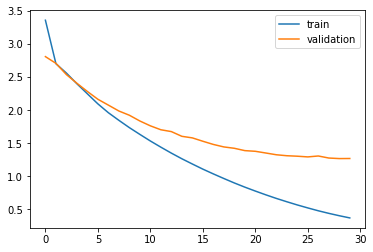

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
#LOAD MODEL
model = load_model('translation_model')
preds = model.predict_classes(X_test.reshape((X_test.shape[0],X_test.shape[1])))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
#Convert predictions into text (English):
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                    temp.append('')
            else:
                    temp.append(t)
        else:
                if(t == None):
                        temp.append('')
                else:
                        temp.append(t) 

    preds_text.append(' '.join(temp))

In [ ]:
#Let’s put the original English sentences in the test dataset and the predicted sentences in a dataframe:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
6375,what did tom want,what did tom want
3296,im listening to you,im hear you
824,youre very modest,youre very humble
1484,it was too late,it was too
9484,this is really bad,this is bad
5036,tom was very sick,tom was really ill
5821,she has short hair,she has long hair
5360,where did i put it,where did i get it
9354,its balmy today,its is today
4889,i cant leave tom,i cant let tom
